# Anomaly Detection using One-Class Support Vector Machine
* **This document contains the explanation and implementation of One-class SVM for detecting anomalies in IOT sensors**
* **It is implemented in 2 ways:**
* _On correlation data: to detect abnormal streams_
* _On individual sensor's data: to detect abnormal readings_
* **Authors: Joy Jayesh Patel and Mariam Sulemana Banda**
* **Student ID: s223966931 and s222565351**

# What is One-Class SVM (Simplified)

One-Class Support Vector Machine (OC-SVM) is an unsupervised machine learning algorithm used to detect anomalies or outliers when **most of the data samples are of normal behavior.**

**Key Idea:**

1. OC-SVM tries to learn the boundary that encloses most of the “normal” data in a high-dimensional space.
2. Later, when a new datapoint or input is given, it checks if that point lies inside or outside the learned boundary.
3. If the point lies **inside** the boundary, it means it is **normal**, and if it's **outside**, it is considered as an **anomaly**.

**How it works:**

1. OC-SVM creates a hypersphere or hyperplane in the data space using an SVM algorithm.
2. Most of the training points lie within this region.
3. Anything outside this region in test data is flagged as an anomaly.

# When is OC-SVM Useful

✅ **Best Use Cases:**

- Only normal data available for training (or mostly normal).
- Anomalies are rare and different from normal patterns.
- Common in:
  - Network intrusion detection  
  - Fault detection in machines  
  - Financial fraud detection  
  - Sensor or IoT anomaly detection  

❌ **Not ideal when:**

- There are labeled anomalies (then supervised models are better).
- Data is highly noisy or drifting — OC-SVM is sensitive to that.
- Not enough consistent normal data for training.

# Key parameters
The **_nu_** is a regularization parameter in One-Class SVM that **controls** the trade-off between **false positives and false negatives**, and it serves two key purposes:

1. Sets an **upper bound** on the fraction of training errors (i.e., how many points can be considered outliers or anomalies).
2. Sets a **lower bound** on the fraction of support vectors (i.e., points that define the decision boundary).

* nu = 0.1 → at most 10% of the training data can be treated as anomalies.
* nu = 0.2 → at most 20% of the training data can be treated as anomalies.
* Smaller nu → more conservative (fewer anomalies).
* Larger nu → more permissive, might flag more points as outliers.

In our case, we used:

1. Kernel: RBF (Radial Basis Function)
2. Gamma: 'auto' (automatically adjusts based on the number of features)
3. nu: 0.05, 0.10, 0.15 and 0.20 

# Implementation

## Implementation on Correlation data ( done by Joy Jayesh Patel )

In [136]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importing necessary files
# Importing the dataset 
data = pd.read_csv("complex_iot.csv")

# Just to skip the correlation analysis here, a csv file containing the correlation scores between the sensor streams in complex.csv has been imported here. 
corr_df = pd.read_csv("correlation_for_ocsvm.csv")

The dataframe corr_df contains the window's start index, window's end index, and pairwise correlations between each stream which will be used for implementing One-class SVM

First we will look at the correlation analysis and then we will implement One-class SVM:

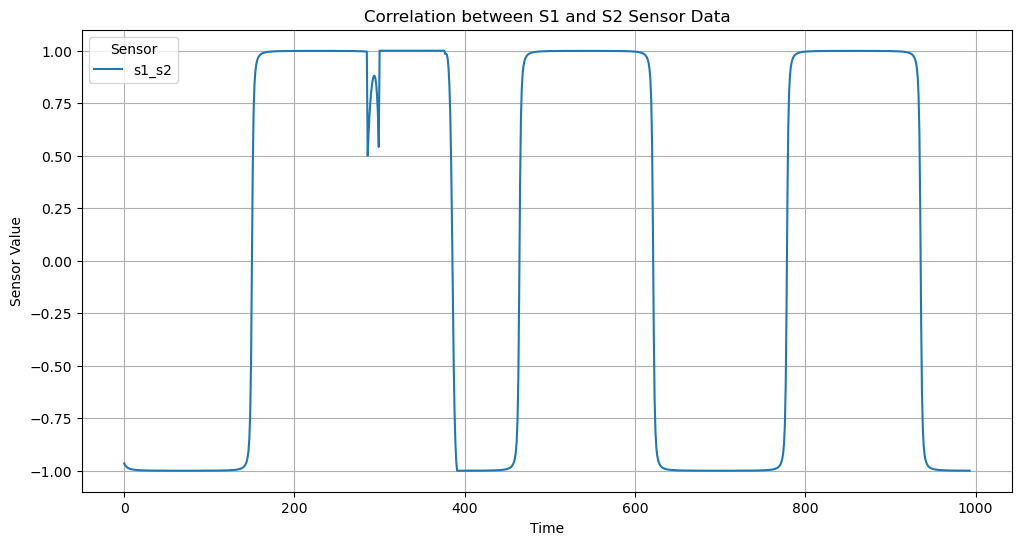

In [137]:
# Plotting correlation between s1 and s2
corr_df['s1_s2'].plot(figsize=(12, 6), title='Correlation between S1 and S2 Sensor Data')
plt.xlabel('Time')
plt.ylabel('Sensor Value')
plt.legend(title='Sensor')
plt.grid(True)
plt.show()

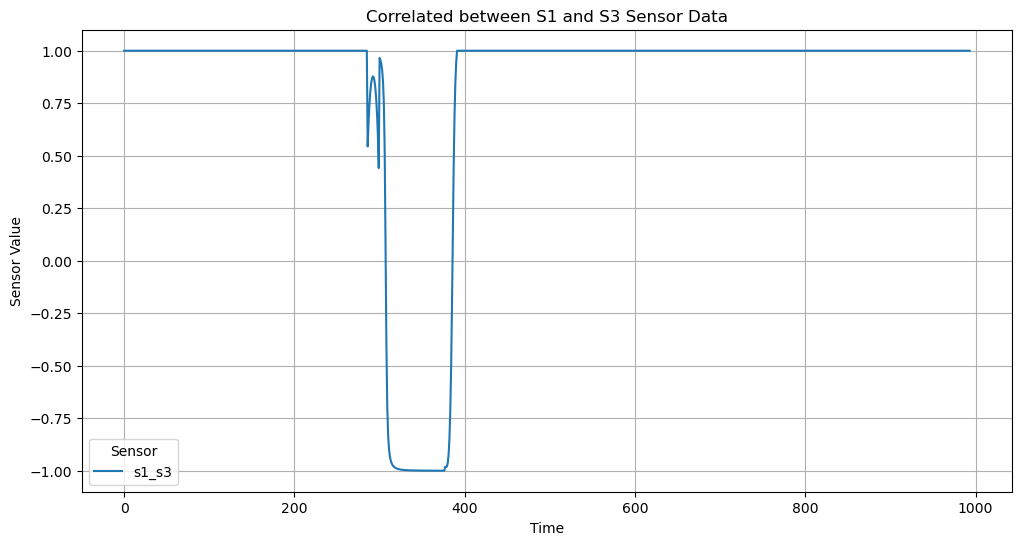

In [138]:
# Plotting correlation between s1 and s3
corr_df['s1_s3'].plot(figsize=(12, 6), title='Correlated between S1 and S3 Sensor Data')
plt.xlabel('Time')
plt.ylabel('Sensor Value')
plt.legend(title='Sensor')
plt.grid(True)
plt.show()

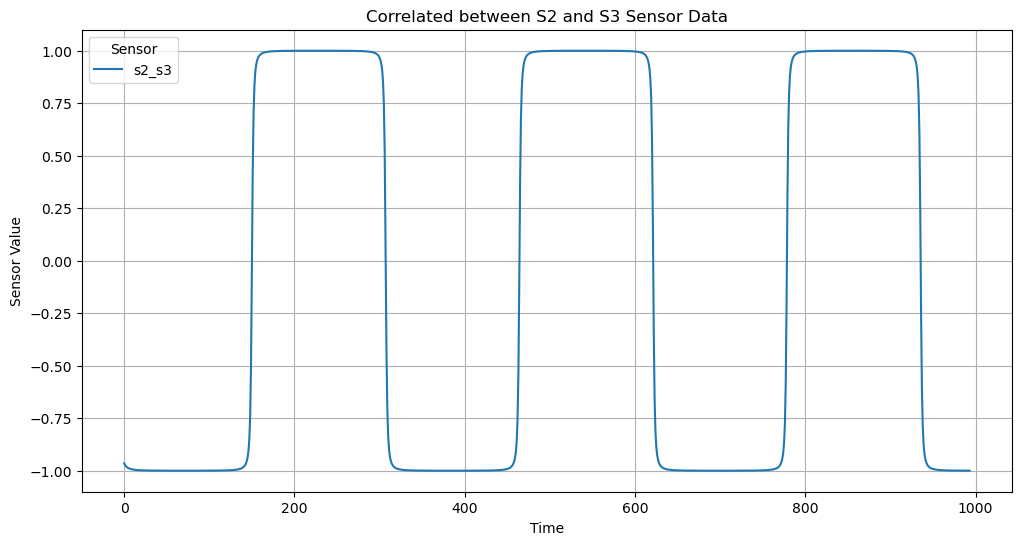

In [139]:
# Plotting correlation between s2 and s3
corr_df['s2_s3'].plot(figsize=(12, 6), title='Correlated between S2 and S3 Sensor Data')
plt.xlabel('Time')
plt.ylabel('Sensor Value')
plt.legend(title='Sensor')
plt.grid(True)
plt.show()

### Observations made from the correlation analysis:
1. Correlation between S1 and S2 alternates between -1 and +1 and some values between [0.5,1].
2. Correlation between S1 and S3 is mostly +1, for some values in between though it fluctuates between 0.5 to 1.
3. Correlation between S2 and S3 alternates between -1 and +1.

Since we want more normal behaviour, we will choose correlation between S1 and S3 and implement the model using only 1 feature. 

Ideally, we would want data that has more normal behaviour so that when an actual anomaly comes, it can correctly detect it.

### Approaches for implementation

Since the correlation data for streams in "complex.csv" is highly ambiguous and no normal pattern or behaviour is observed(which is mandatory for One-class SVM), it's difficult to perform the One-class SVM the model on it.

So, we implement it into 2 ways: 
1. One with 3 features: pairwise correlation between all streams
2. One with only 1 feature: pairwise correlation between S1 and S3 ( as it has more normal data )

In [140]:
# Removing any whitespaces from the column names
data.columns = data.columns.str.strip()

In [141]:
data

,time,s1,s2,s3
0,0,1.000000,2.000000,0.700000
1,1,1.010000,1.999950,0.707000
2,2,1.019999,1.999800,0.713999
3,3,1.029996,1.999550,0.720997
4,4,1.039989,1.999200,0.727993
...,...,...,...,...
1003,1003,0.431055,0.177624,0.301739
1004,1004,0.422860,0.183355,0.296002
1005,1005,0.414723,0.189167,0.290306
1006,1006,0.406644,0.195060,0.284651


## Using 3 features
The 3 features are the correlation between s1 and s2, s1 and s3, and s2 and s3

#### Preprocessing the data

In [142]:
from sklearn.preprocessing import StandardScaler

#Extracting the 3 features
data_with_3_features = corr_df[['s1_s2','s1_s3','s2_s3']]

# Convert to array
data_3_features_array = data_with_3_features.values  

#Scaling the data
scaler = StandardScaler()
scaled_3_features = scaler.fit_transform(data_3_features_array)

#### Train and Test splits

In [143]:
# Training on first 700
train_with_3 = scaled_3_features[:700]

# Testing on rest points
test_with_3 = scaled_3_features[700:]

#### Training the model on training data

In [144]:
from sklearn.svm import OneClassSVM
oc_svm_3 = OneClassSVM(kernel='rbf', nu=0.20, gamma='scale')
oc_svm_3.fit(train_with_3)

OneClassSVM(nu=0.2)

#### Testing

In [159]:
y_pred_for_3 = oc_svm_3.predict(test_with_3)

# Adding predictions to the 3 features dataframe
data_with_3_features.loc[700:,'anomaly'] = y_pred_for_3

# Extracting the anomalies into an anomalies dataframe for visualization
anomalies_3 = data_with_3_features[data_with_3_features['anomaly']==-1]

## Using 1 feature
The 1 features is the correlation between s1 and s3 as it had the most normal values for training

#### Preprocessing the data

In [146]:
# Extracting the only 1 feature
data_with_1_feature = corr_df[['s1_s3']]

#Converting into array
data_1_feature_array = data_with_1_feature.values

#Scaling the data
scaler = StandardScaler()
scaled_1_feature = scaler.fit_transform(data_1_feature_array)

#### Train and Test splits

In [147]:
# Training on first 700 data points
train_with_1 = scaled_1_feature[:700]

# Testing on rest
test_with_1 = scaled_1_feature[700:]

#### Training the model on training data

In [148]:
from sklearn.svm import OneClassSVM
oc_svm_1 = OneClassSVM(kernel='rbf', nu=0.20, gamma='scale')
oc_svm_1.fit(train_with_1)

OneClassSVM(nu=0.2)

#### Testing

In [158]:
y_pred_for_1 = oc_svm_1.predict(test_with_1)

# Add predictions to the 1 feature dataframe
data_with_1_feature.loc[700:,'anomaly'] = y_pred_for_1

#Extracting the anomalies into an anomalies dataframe for visualization
anomalies_1 = data_with_1_feature[data_with_1_feature['anomaly']==-1]

#### Visualizations and Results

#### 3-feature approach

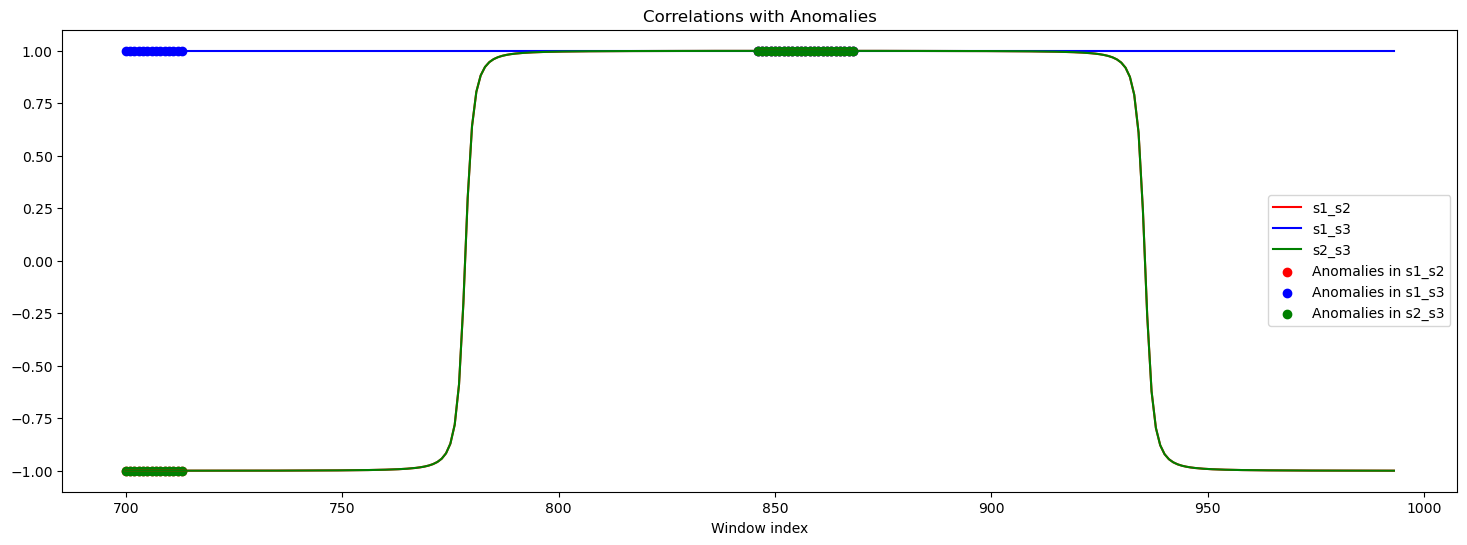

The number of anomalies in 3 feature approach: 37
Anomaly ratio: 12.59%


In [150]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))

#Plots the columns
plt.plot(data_with_3_features.loc[700:].index, data_with_3_features['s1_s2'].loc[700:], color='red', label='s1_s2')
plt.plot(data_with_3_features.loc[700:].index, data_with_3_features['s1_s3'].loc[700:], color='blue', label='s1_s3')
plt.plot(data_with_3_features.loc[700:].index, data_with_3_features['s2_s3'].loc[700:], color='green', label='s2_s3')


#Plots the anomalies in that column
plt.scatter(anomalies_3.index, anomalies_3['s1_s2'], color='red', label='Anomalies in s1_s2')
plt.scatter(anomalies_3.index, anomalies_3['s1_s3'], color='blue', label='Anomalies in s1_s3')
plt.scatter(anomalies_3.index, anomalies_3['s2_s3'], color='green', label='Anomalies in s2_s3')
plt.legend()
plt.title('Correlations with Anomalies')
plt.xlabel('Window index')
plt.show()

# Counting the number of anomalies
print("The number of anomalies in 3 feature approach:", anomalies_3['anomaly'].count())

anomaly_ratio_3 = (y_pred_for_3 == -1).mean()
print(f"Anomaly ratio: {anomaly_ratio_3:.2%}")

Observations: 
* It does classify few points as outliers, but it has few problems. 
* This model learns from 3 different correlation values which are highly ambiguous.
* For points 700 to 715, it classifies both +1 and -1 as anomalies. This is misleading and conflicting with the fact that it also classifies points from around 850 to 875 as anomalies as well where the values are equal.
* Difficult to evaluate as we don't know 12.59% anomaly ratio is good or bad. Hence I used 1 feature approach
So the conclusion from this would be for multiple features, we need more data that has normal behaviour so that the model can learn well. 

#### 1-feature approach

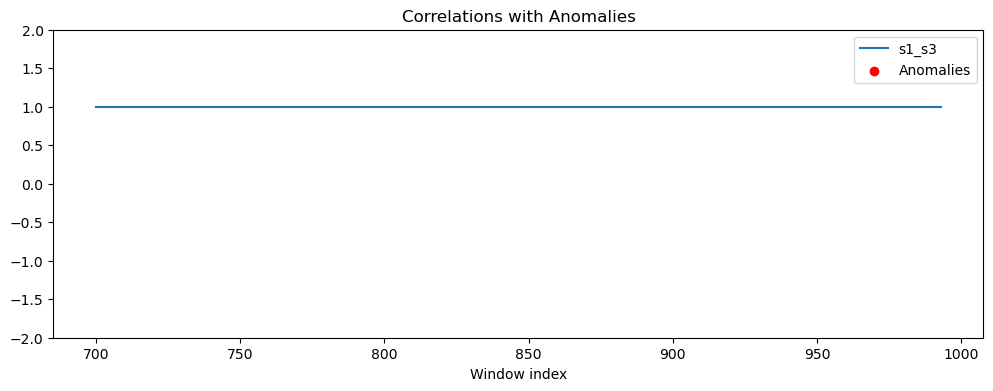

The number of anomalies in 1 feature approach: 0
Anomaly ratio in 1 feature approach: 0.00%


In [151]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(data_with_1_feature.loc[700:].index, data_with_1_feature['s1_s3'].loc[700:], label='s1_s3')
plt.scatter(anomalies_1.index, anomalies_1['s1_s3'], color='red', label='Anomalies')
plt.legend()
plt.title('Correlations with Anomalies')
plt.xlabel('Window index')
plt.ylim(-2,2)
plt.show()


#Counting the number of anomalies
print("The number of anomalies in 1 feature approach:", anomalies_1['anomaly'].count())

anomaly_ratio_1 = (y_pred_for_1 == -1).mean()
print(f"Anomaly ratio in 1 feature approach: {anomaly_ratio_1:.2%}")

Observations: 
* From the plot, we can see that there are no anomalies and the algorithm also didn't classify any data point wrongly. 
* So for this approach we have 100% accuracy.
* Since it was trained using just 1 feature, it was a very simple model (model learned it very easily), we got the perfect results 

## Anomalies Detected

#### Testing on last 30% of the data

| nu   | Anomaly ratio for 3 features | Anomaly ratio for 1 feature |
|------|-----------------------------|-----------------------------|
| 0.05 | 11.22%                      | 0%                          |
| 0.10 | 5.44%                       | 0%                          |
| 0.15 | 7.48%                       | 0%                          |
| 0.20 | 12.59%                      | 0%                          |

#### Testing on entire dataset

| nu   | Anomaly ratio for 3 feature | No. of anomalies (3 feature) | Anomaly ratio for 1 feature | No. of anomalies (1 feature) |
|------|-----------------------------|------------------------------|-----------------------------|------------------------------|
| 0.05 | 11.37%                      | 113                          | 2.31%                       | 23                           |
| 0.10 | 10.76%                      | 107                          | 4.63%                       | 46                           |
| 0.15 | 12.47%                      | 124                          | 6.66%                       | 66                           |
| 0.20 | 19.62%                      | 195                          | 8.75%                       | 87                           |

!['Anomaly Plot of 3 feature One-class SVM tested on entire dataset with nu=0.10'](feat_3_nu10_all.png)

**Figure 1: The above plot shows the anomaly detection results of 3 feature One-class SVM tested on entire dataset with nu=10.**

!['Anomaly Plot of 1 feature One-class SVM tested on entire dataset with nu=0.10'](feat_1_nu10_all.png)

**Figure 2: The above plot shows the anomaly detection results of 1 feature One-class SVM tested on entire dataset with nu=10.**

As we can see, in the model trained using 3 features, the anomalies are very random whereas in 1 feature the anomalies are quite justified. 

#### Additional comparision with Correlation Analysis

The below images show the anomalies detected using Correlation analysis

!['Anomaly detection between s1 and s2 using correlation analysis'](s1_s2_below_08.png)

!['Anomaly detection between s1 and s3 using correlation analysis '](s1_s3_below_08.png)

!['Anomaly detection between s2 and s3 using correlation analysis'](s2_s3_below_08.png)

## Final Conclusion for Correlation based implementation

The 1 feature approach to train the model was done just to demonstrate why **DATA WITH NORMAL BEHAVIOUR** is required for One-class SVM. In higher dimensions, this is much more important else the model will wrongly classify the datapoints as anomalies

# Implementation on Individual Sensor Data ( done by Mariam Sulemana Banda ) 

In [152]:
import pandas as pd
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

# Set Plotly renderer
pio.renderers.default = 'notebook_connected'

# Load and clean data
df = pd.read_csv('complex_iot.csv')
df.columns = df.columns.str.strip()

## Implementation on complex.csv

We applied the One-Class SVM algorithm on time-series data from three sensors: s1, s2, and s3.

Preprocessing:

    Rolling window features (mean and std with window size = 10)
    Lag features (1-step and 2-step lag)
    Standardized all features before model training
    Each sensor was processed independently to detect anomalies in its signal pattern.

In [153]:
# Create rolling features
window_size = 10
for col in ['s1', 's2', 's3']:
    df[f'{col}_mean'] = df[col].rolling(window=window_size).mean()
    df[f'{col}_std'] = df[col].rolling(window=window_size).std()
    df[f'{col}_lag1'] = df[col].shift(1)
    df[f'{col}_lag2'] = df[col].shift(2)

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [154]:
summary = {}
for sensor in ['s1', 's2', 's3']:
    features = [f'{sensor}_mean', f'{sensor}_std', f'{sensor}_lag1', f'{sensor}_lag2']
    X = StandardScaler().fit_transform(df[features])
    
    model = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
    df[f'{sensor}_anomaly'] = model.fit_predict(X)
    df[f'{sensor}_is_anomaly'] = df[f'{sensor}_anomaly'].apply(lambda x: 1 if x == -1 else 0)

    summary[sensor] = {
        "total_points": len(df),
        "anomalies": df[f'{sensor}_is_anomaly'].sum(),
        "anomaly_rate": round(100 * df[f'{sensor}_is_anomaly'].mean(), 2),
        "trend": "increasing" if df[sensor].iloc[-1] > df[sensor].iloc[0] else "decreasing"
    }

In [163]:
for sensor in ['s1', 's2', 's3']:
    anomalies = df[df[f'{sensor}_is_anomaly'] == 1]

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=df['time'],
        y=df[sensor],
        mode='lines',
        name='Normal',
        line=dict(color='blue', width=2)
    ))

    fig.add_trace(go.Scatter(
        x=anomalies['time'],
        y=anomalies[sensor],
        mode='markers',
        name='Anomalies',
        marker=dict(color='red', size=8, symbol='x'),
        hovertemplate='Time: %{x}<br>Value: %{y}<extra>Anomaly</extra>'
    ))

    fig.update_layout(
        title=f"Anomaly Detection for {sensor.upper()} – {summary[sensor]['anomalies']} anomalies",
        xaxis_title='Time',
        yaxis_title='Sensor Value',
        height=500
    )
    fig.show()

In [156]:
print("=== Anomaly Detection Summary ===\n")
for sensor in ['s1', 's2', 's3']:
    print(f"Sensor: {sensor.upper()}")
    print(f"  Total Points: {summary[sensor]['total_points']}")
    print(f"  Anomalies Detected: {summary[sensor]['anomalies']} ({summary[sensor]['anomaly_rate']}%)")
    print(f"  Trend: {summary[sensor]['trend'].capitalize()}")
    print()

=== Anomaly Detection Summary ===

Sensor: S1
  Total Points: 999
  Anomalies Detected: 50 (5.01%)
  Trend: Decreasing

Sensor: S2
  Total Points: 999
  Anomalies Detected: 51 (5.11%)
  Trend: Decreasing

Sensor: S3
  Total Points: 999
  Anomalies Detected: 51 (5.11%)
  Trend: Decreasing



In [157]:
summary_df = pd.DataFrame([
    {"Sensor": sensor.upper(), "Anomalies": summary[sensor]["anomalies"], "Anomaly Rate (%)": summary[sensor]["anomaly_rate"]}
    for sensor in ['s1', 's2', 's3']
])

bar_fig = px.bar(
    summary_df,
    x="Sensor", y="Anomalies", text="Anomaly Rate (%)",
    title="Total Anomalies Detected per Sensor",
    labels={"Anomalies": "Number of Anomalies"}
)

bar_fig.update_traces(textposition="outside")
bar_fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
bar_fig.show()

## Evaluation & Future Recommendations
The One-Class SVM model successfully detected subtle deviations across sensors. The anomaly locations are visually interpretable and consistent with expected behavior.

* Recommendation:

We recommend continuing to use One-Class SVM as a baseline model in future trimesters or for similar datasets, especially where:

Anomalous data is rare or unlabeled
Transparency and ease of implementation are desired

* Possible Improvements:

Use Isolation Forest or LSTM for higher accuracy in noisy environments
Implement real-time streaming detection
